In [264]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot

import gzip
import json

%load_ext memory_profiler

plt.rcParams['figure.figsize'] = [20, 5]

print(tf.__version__)

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
2.6.0


In [2]:
if tf.test.gpu_device_name(): 
    print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

else:
    print("Please install GPU version of TF")

Default GPU Device:/device:GPU:0


In [618]:
imdb_data = pd.read_csv(r"C:\Users\stezo\Desktop\Text_classification\IMDB Dataset.csv",encoding='latin-1')

In [619]:
def clean_text(text ): 
    delete_dict = {sp_character: '' for sp_character in string.punctuation} 
    delete_dict[' '] = ' ' 
    table = str.maketrans(delete_dict)
    text1 = str(text).translate(table)
    #print('cleaned:'+text1)
    textArr= text1.split()
    text2 = ' '.join([w for w in textArr if ( not w.isdigit() and  ( not w.isdigit() and len(w)>2))]) 
    
    return text2.lower()

In [620]:
%time imdb_data['text'].dropna(axis = 0, how ='any',inplace=True) 

%time imdb_data['text'] = imdb_data['text'].apply(clean_text)

Wall time: 5.99 ms
Wall time: 5.54 s


In [621]:
imdb_data['label'] = imdb_data['label'].apply(lambda x: 1 if x == 'positive' else 0 )
imdb_data['label'].value_counts()

1    25000
0    25000
Name: label, dtype: int64

In [636]:
# Podział na zbiór trenningowy oraz testowy.
X_train, X_valid, y_train, y_valid = train_test_split(imdb_data['text'].tolist(),
                                                      imdb_data['label'].tolist(),
                                                      train_size=0.5,
                                                      test_size=0.3,
                                                      stratify = imdb_data['label'].tolist(),\
                                                      random_state=0)


In [637]:
num_words = 5000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[1, 63, 14, 13]]


In [638]:
x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )

sequence_length = 200
x_train = pad_sequences(x_train, padding='post', maxlen=sequence_length)
x_valid = pad_sequences(x_valid, padding='post', maxlen=sequence_length)

train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))

sequence_length_cnn = 200
x_train_cnn = pad_sequences(x_train, padding='post', maxlen=sequence_length_cnn)
x_valid_cnn = pad_sequences(x_valid, padding='post', maxlen=sequence_length_cnn)


train_ds_cnn = tf.data.Dataset.from_tensor_slices((x_train_cnn,train_labels))
valid_ds_cnn = tf.data.Dataset.from_tensor_slices((x_valid_cnn,valid_labels))

C:\Users\stezo\AppData\Local\Temp/ipykernel_11332/138712046.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_train = np.array( tokenizer.texts_to_sequences(X_train) )
C:\Users\stezo\AppData\Local\Temp/ipykernel_11332/138712046.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )


In [639]:
max_features =5000
embedding_dim =16
sequence_length_rnn = sequence_length
RNN = tf.keras.Sequential()
RNN.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length_rnn,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
RNN.add(tf.keras.layers.Dropout(0.2))
RNN.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.3, recurrent_dropout=0,return_sequences=True,
                                                             kernel_regularizer=regularizers.l2(0.005),
                                                             bias_regularizer=regularizers.l2(0.005)))
RNN.add(tf.keras.layers.Flatten())

RNN.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001), input_shape=(160,10)))
RNN.add(tf.keras.layers.Dropout(0.2))

RNN.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
RNN.add(tf.keras.layers.Dropout(0.2))
RNN.add(tf.keras.layers.Dense(1,activation='sigmoid'))
#RNN.summary()
RNN.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                             optimizer=tf.keras.optimizers.Adam(1e-3),
                             metrics=[tf.keras.metrics.BinaryAccuracy()])

In [640]:
%%time
epochs = 20
historyRNN = RNN.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=0)

print(f"RNN accuracy ->: {round(historyRNN.history['binary_accuracy'][-1], 5)}")

RNN accuracy ->: 0.89544
Wall time: 15.5 s


In [641]:
print(f"RNN accuracy ->: {round(historyRNN.history['binary_accuracy'][-1], 5)*100}%")
print(f"RNN val accuracy ->: {round(historyRNN.history['val_binary_accuracy'][-1], 5)*100}%")

RNN accuracy ->: 89.544%
RNN val accuracy ->: 86.32%


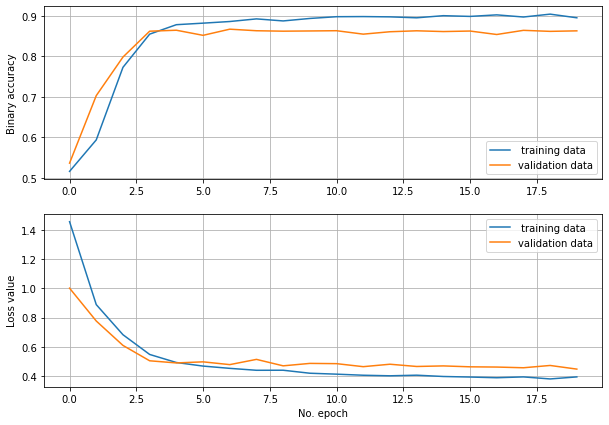

In [642]:
# plot 
plt.rcParams['figure.figsize'] = [10, 7]

f, axs = plt.subplots(2, 1)
#axs[0].subplot(211)
axs[0].plot(historyRNN.history['binary_accuracy'], label=' training data')
axs[0].plot(historyRNN.history['val_binary_accuracy'], label='validation data')
#axs[0].set_title('Binary accuracy for Text Classification')
axs[0].set_ylabel('Binary accuracy')
#axs[0].set_xlabel('No. epoch')
axs[0].legend(loc="lower right")
axs[0].grid(True)

axs[1].plot(historyRNN.history['loss'], label=' training data')
axs[1].plot(historyRNN.history['val_loss'], label='validation data')
#axs[1]title('Loss for Text Classification')
axs[1].set_ylabel('Loss value')
axs[1].set_xlabel('No. epoch')
axs[1].legend(loc="upper right")
axs[1].grid(True)


In [589]:
embedding_dim = 16

modelCNN = tf.keras.Sequential()
modelCNN.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, 
                                       input_length=sequence_length_cnn,
                                       embeddings_regularizer = regularizers.l2(0.005))) 
modelCNN.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'))
modelCNN.add(tf.keras.layers.MaxPooling1D(pool_size=1))
modelCNN.add(tf.keras.layers.Flatten())
modelCNN.add(tf.keras.layers.Dense(5, activation='relu'))
modelCNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

modelCNN.compile(loss='binary_crossentropy', optimizer='adam', metrics=tf.keras.metrics.BinaryAccuracy())
#modelCNN.summary()

In [590]:
%%time
epochs = 20
historyCNN = modelCNN.fit(train_ds_cnn.shuffle(5000).batch(1024),
                       epochs= epochs, 
                       validation_data=valid_ds_cnn.batch(1024), 
                       verbose=0)

print(f"CNN accuracy ->: {round(historyCNN.history['binary_accuracy'][-1], 5)}")

CNN accuracy ->: 0.89476
Wall time: 8.56 s


In [591]:
print(f"CNN accuracy ->: {round(historyCNN.history['binary_accuracy'][-1], 5)*100}%")
print(f"CNN val accuracy ->: {round(historyCNN.history['val_binary_accuracy'][-1], 5)*100}%")

CNN accuracy ->: 89.476%
CNN val accuracy ->: 87.72%


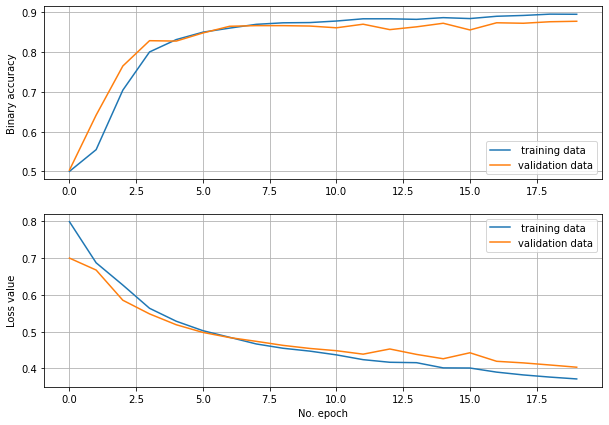

In [592]:
# plot 
plt.rcParams['figure.figsize'] = [10, 7]

f, axs = plt.subplots(2, 1)
#axs[0].subplot(211)
axs[0].plot(historyCNN.history['binary_accuracy'], label=' training data')
axs[0].plot(historyCNN.history['val_binary_accuracy'], label='validation data')
#axs[0].set_title('Binary accuracy for Text Classification')
axs[0].set_ylabel('Binary accuracy')
#axs[0].set_xlabel('No. epoch')
axs[0].legend(loc="lower right")
axs[0].grid(True)

axs[1].plot(historyCNN.history['loss'], label=' training data')
axs[1].plot(historyCNN.history['val_loss'], label='validation data')
#axs[1]title('Loss for Text Classification')
axs[1].set_ylabel('Loss value')
axs[1].set_xlabel('No. epoch')
axs[1].legend(loc="upper right")
axs[1].grid(True)